# **DEEP LEARNING FOR COMPUTER SYSTEM**
# **Chapter 4: Project Structuring and Hyperparameter tuning**


## **Improve Images classification with CNN on CIFAR-10 dataset**

---

## 1. Get the data ready for training

In [1]:
from keras.datasets import cifar10

# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [2]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [3]:
# split train-val
(X_train, X_val) = X_train[5000:], X_train[:5000]
(y_train, y_val) = y_train[5000:], y_train[:5000]

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)

X_train shape:  (45000, 32, 32, 3)
X_val shape:  (5000, 32, 32, 3)


Note: only normalize val and test set with mean and std caculated from train set.

In [4]:
# normalize input
import numpy as np

mean = np.mean(X_train, axis=(0,1,2,3))
std = np.std(X_train, axis=(0,1,2,3))
epsilon = 1e-7

X_train = (X_train - mean)/(std+epsilon)
X_val = (X_val - mean)/(std+epsilon)
X_test = (X_test - mean)/(std+epsilon)

In [5]:
# Encode categorical label using one-hot
from keras.utils import to_categorical

n_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

In [6]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

## 2. Build the Model's Architecture

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,\
  BatchNormalization
from keras import regularizers, optimizers

base_hidden_units = 32
w_decay = 1e-4

model = Sequential()

# CONV1
model.add(Conv2D(filters=base_hidden_units, kernel_size=3, padding='same',
                 kernel_regularizer=regularizers.l2(w_decay),
                 activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(filters=base_hidden_units, kernel_size=3, padding='same',
                 kernel_regularizer=regularizers.l2(w_decay),
                 activation='relu'))
model.add(BatchNormalization())

# POOL+Dropout
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(filters=2*base_hidden_units, kernel_size=3, padding='same',
                 kernel_regularizer=regularizers.l2(w_decay),
                 activation='relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(filters=2*base_hidden_units, kernel_size=3, padding='same',
                 kernel_regularizer=regularizers.l2(w_decay),
                 activation='relu'))
model.add(BatchNormalization())

# POOL+Dropout
model.add(MaxPooling2D())
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(filters=4*base_hidden_units, kernel_size=3, padding='same',
                 kernel_regularizer=regularizers.l2(w_decay),
                 activation='relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(filters=4*base_hidden_units, kernel_size=3, padding='same',
                 kernel_regularizer=regularizers.l2(w_decay),
                 activation='relu'))
model.add(BatchNormalization())

# POOL+Dropout
model.add(MaxPooling2D())
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

*Non-trainable params means the number of weights that are not updated during training with backpropagation.*

There are mainly two types of non-trainable weights:

- The ones that you have chosen to keep constant when training. This means that keras won't update these weights during training at all.
- The ones that work like statistics in BatchNormalization layers. They're updated with mean and variance, but they're not "trained with backpropagation"

params # of BN layer = 4 * depth
Non-trainable params = 2 * depth

## 3. Train the model

In [8]:
batch_size = 64
epochs = 125

In [9]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5',
                                    verbose=1, save_best_only=True)

optimizer = optimizers.RMSprop(learning_rate=0.0001, weight_decay=1e-6)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

In [11]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size),
                           callbacks=[checkpointer], epochs = epochs, verbose=2,
                           steps_per_epoch=len(X_train)//batch_size,
                           validation_data=(X_val, y_val))

Epoch 1/125

Epoch 1: val_loss improved from inf to 1.61407, saving model to model.weights.best.hdf5
703/703 - 40s - loss: 2.5965 - accuracy: 0.2966 - val_loss: 1.6141 - val_accuracy: 0.4500 - 40s/epoch - 57ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/125

Epoch 2: val_loss improved from 1.61407 to 1.44235, saving model to model.weights.best.hdf5
703/703 - 33s - loss: 1.9314 - accuracy: 0.3923 - val_loss: 1.4424 - val_accuracy: 0.5062 - 33s/epoch - 47ms/step
Epoch 3/125

Epoch 3: val_loss improved from 1.44235 to 1.41475, saving model to model.weights.best.hdf5
703/703 - 31s - loss: 1.7035 - accuracy: 0.4507 - val_loss: 1.4148 - val_accuracy: 0.5302 - 31s/epoch - 44ms/step
Epoch 4/125

Epoch 4: val_loss improved from 1.41475 to 1.29435, saving model to model.weights.best.hdf5
703/703 - 31s - loss: 1.5467 - accuracy: 0.4948 - val_loss: 1.2943 - val_accuracy: 0.5696 - 31s/epoch - 44ms/step
Epoch 5/125

Epoch 5: val_loss did not improve from 1.29435
703/703 - 29s - loss: 1.4450 - accuracy: 0.5242 - val_loss: 1.3070 - val_accuracy: 0.5664 - 29s/epoch - 42ms/step
Epoch 6/125

Epoch 6: val_loss improved from 1.29435 to 1.19562, saving model to model.weights.best.hdf5
703/703 - 32s - loss: 1.3466 - accuracy: 0.5535 - val_loss: 1.19

## 4. Evaluate

In [12]:
model.load_weights('model.weights.best.hdf5')

In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: %.2f%%' % (score[1]*100))

Test accuracy: 86.34%


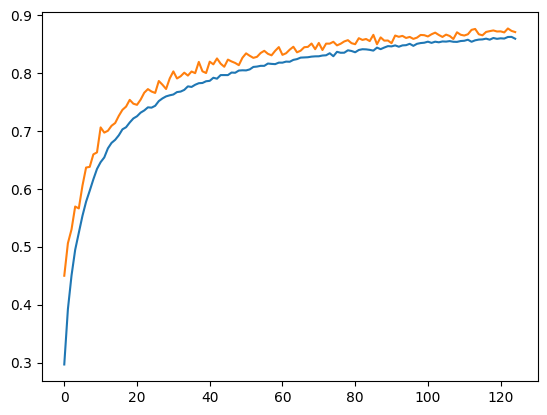

In [15]:
# plot learning curve
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')